-  Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

-  Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

-  Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

-  Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

-  Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

-  Estimate a bounding box for vehicles detected.

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import os
%matplotlib inline

#Read in the training data
car_images = glob.glob('vehicles/*/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*/*.png')
print(len(car_images), len(noncar_images))

8792 8968


Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                   
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Text(0.5,1,'HOG Visualization')

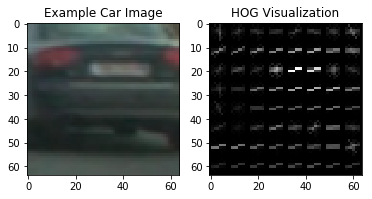

In [3]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, flag = True, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    
    if flag == True:
    # Iterate through the list of images
        features = []
        for file in imgs:
            image = mpimg.imread(file)
            #image = cv2.resize(image, dsize = (64,64))
            file_features = []
            # Read in each one by one
            # apply color conversion if other than 'RGB'
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else:
                feature_image = np.copy(image)

            if spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=(16,16))
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
                # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                             orient, pix_per_cell, cell_per_block,
                                                             vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
        return np.array(features)
    else:
        #single image!!
        img_features = []

        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(imgs)      
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=(16,16))
            #4) Append features to list
            img_features.append(spatial_features)

        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            #img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                             orient, pix_per_cell, cell_per_block,
                                                             vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
            else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
            img_features.append(hog_features)
        return np.concatenate(img_features)


In [5]:
# Feature extraction and training of the Linear SVM Classifier
color_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
spatial_size=(16,16)

positive_features = extract_features(car_images, color_space = color_space, orient=orient, 
                                     hog_channel = hog_channel, spatial_feat = spatial_feat, 
                                     spatial_size=(16,16), pix_per_cell = pix_per_cell, cell_per_block = 2)
#print(positive_features.shape)
negative_features = extract_features(noncar_images, color_space = color_space, orient = orient, hog_channel = hog_channel, spatial_feat = spatial_feat, spatial_size=(16,16), pix_per_cell = pix_per_cell, cell_per_block = 2)
#print(negative_features.shape)

'''positive_features = extract_features(car_images, hog_channel= 'ALL')
negative_features = extract_features(noncar_images, hog_channel = 'ALL')'''

# Array of feature vectors
X = np.vstack([positive_features, negative_features]).astype(np.float64)
#print(X.shape)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

# Labels vector
y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))
#print(y.shape)

#Split data
random = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=random)

import time

#Linear SVC
svc = LinearSVC()
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
total_time = round(t2-t1,2)
print('Processing time: ', total_time)
accuracy = svc.score(X_test, y_test)
print ('SVC Accuracy: ', accuracy)


Processing time:  17.93
SVC Accuracy:  0.9850788288288288


Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes

    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [8]:
test_images = glob.glob('test_images/*.jpg')
print(len(test_images))

6


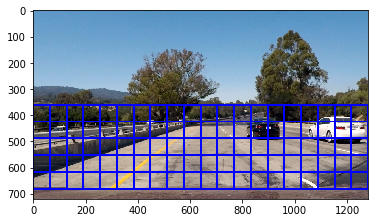

In [9]:
ind = np.random.randint(0, len(test_images))
image = mpimg.imread(test_images[ind])
windows = slide_window(image, y_start_stop = [360, 700], xy_window = (64,64), xy_overlap = (0,0))
window_img = draw_boxes(image, windows, color=(0,0,255), thick=6)
plt.imshow(window_img)


In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(img_window,  color_space=color_space, spatial_size=(16,16),
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        cleanedList = [x for x in features if str(x) != 'nan']
        scaled = scaler.transform(np.array(cleanedList).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(scaled)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

In [11]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=(16,16))
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        #6) Append features to list
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


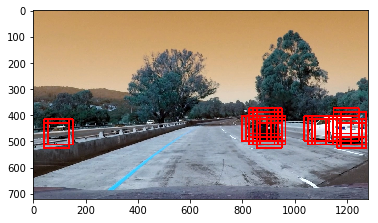

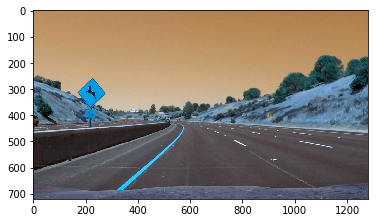

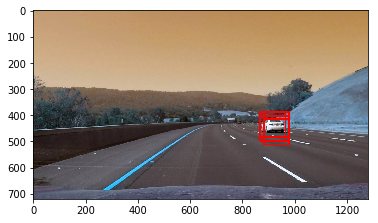

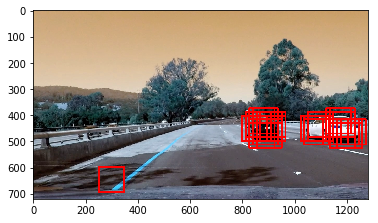

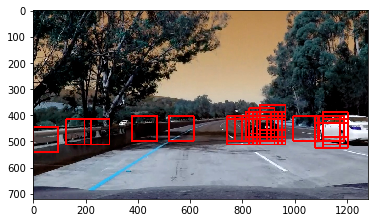

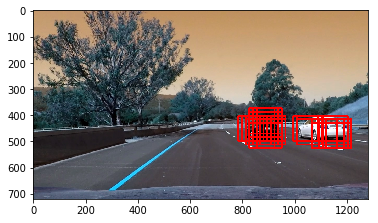

In [12]:
for image in test_images:
    #image = cv2.imread(image)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # normalize.
    image = image.astype(np.float32)/255
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop = [360, 700], xy_window = (96,96), xy_overlap = (0.85,0.85))
    
    hot_windows = []
    hot_windows = (search_windows(image, windows, svc, X_scaler, color_space = color_space, spatial_size = (16, 16), 
                                hist_bins = 32, orient = orient, pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block, hog_channel=hog_channel, spatial_feat = spatial_feat, hist_feat=True, hog_feat=True))
    cars = draw_boxes(draw_image, hot_windows)
    show_img(cars)

Draw heatmap

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

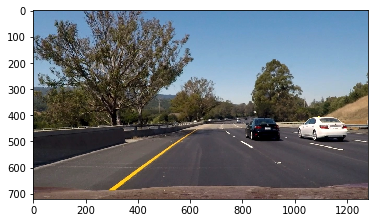

In [14]:
plt.imshow(draw_image)

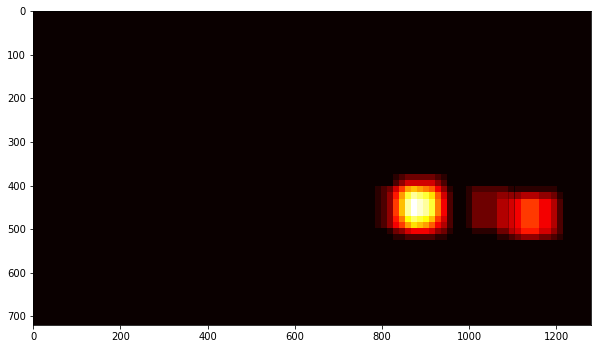

In [15]:
heat_img = np.zeros_like(draw_image[:,:,0]) #hopefully the last one
heat = add_heat(heat_img, hot_windows)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')

In [16]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

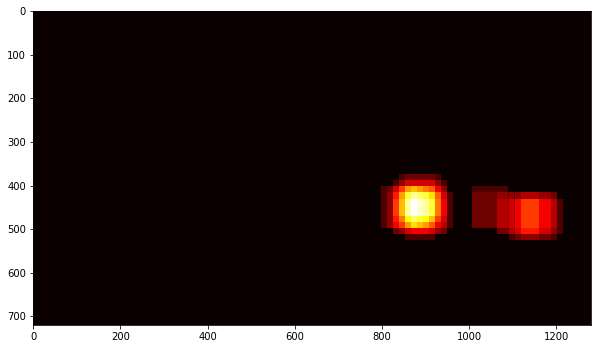

In [17]:
heatmap_img = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [18]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


...


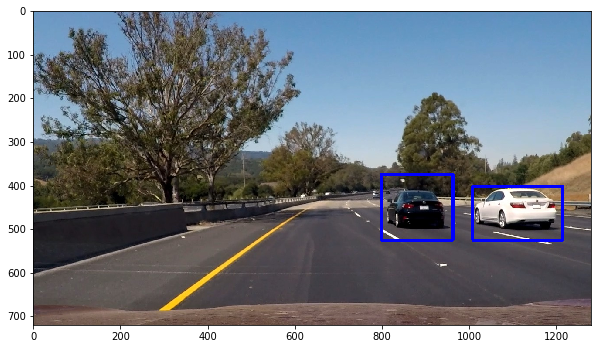

In [19]:
final_image = draw_labeled_bboxes(np.copy(draw_image), labels)
plt.figure(figsize=(10,10))
plt.imshow(final_image)
print('...')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


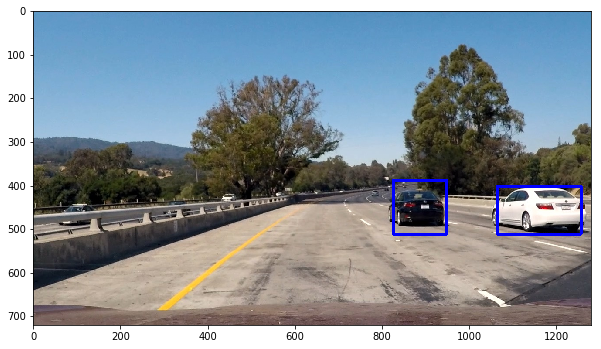

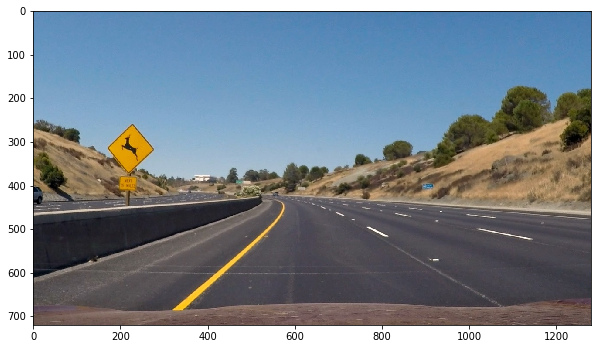

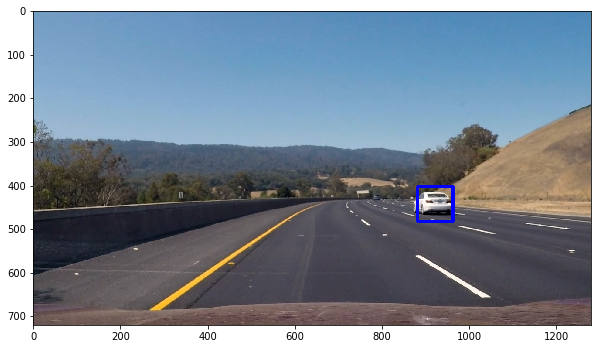

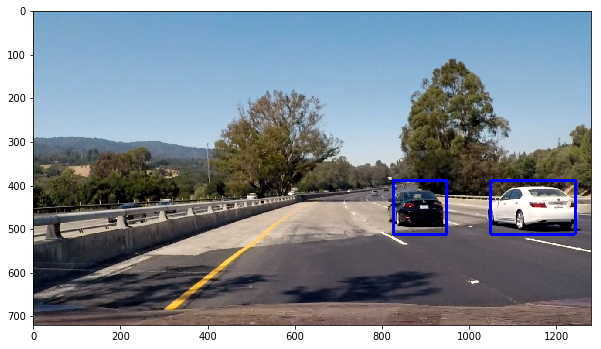

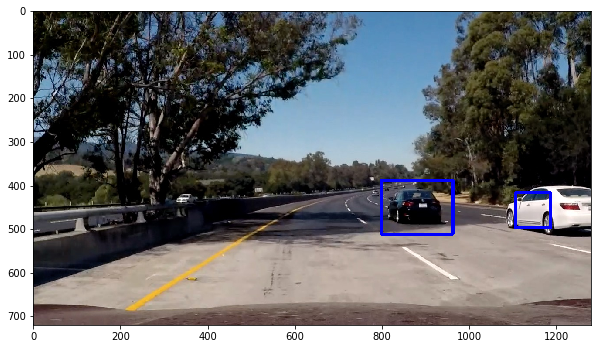

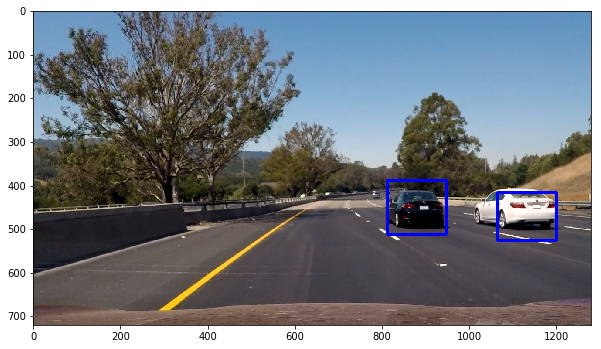

In [20]:
for image in test_images:
    #image = cv2.imread(image)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # normalize.
    image = image.astype(np.float32)/255
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop = [360, 700], xy_window = (96,96), xy_overlap = (0.85,0.85))
    
    hot_windows = []
    hot_windows = (search_windows(image, windows, svc, X_scaler, color_space = color_space, spatial_size = (16, 16), 
                                hist_bins = 32, orient = orient, pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block, hog_channel=hog_channel, spatial_feat = spatial_feat, hist_feat=True, hog_feat=True))
    cars = draw_boxes(draw_image, hot_windows)
    heat_img = np.zeros_like(draw_image[:,:,0])
    heat = add_heat(heat_img, hot_windows)
    heatmap_img = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    final_image = draw_labeled_bboxes(np.copy(draw_image), labels)
    plt.figure(figsize=(10,10))
    plt.imshow(final_image)


Run video

In [24]:
def process_image(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # normalize.
    draw_image1 = np.copy(image)

    image = image.astype(np.float32)/255

    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop = [360, 700], xy_window = (96,96), xy_overlap = (0.85,0.85))
    
    hot_windows = []
    hot_windows = (search_windows(image, windows, svc, X_scaler, color_space = color_space, spatial_size = (16, 16), 
                                hist_bins = 32, orient = orient, pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block, hog_channel=hog_channel, spatial_feat = spatial_feat, hist_feat=True, hog_feat=True))
    cars = draw_boxes(draw_image, hot_windows)
    heat_img = np.zeros_like(draw_image[:,:,0])
    heat = add_heat(heat_img, hot_windows)
    heatmap_img = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    final_image = draw_labeled_bboxes(np.copy(draw_image1), labels)
    
    return final_image

In [25]:
output_vid = 'test_video_out.mp4'
clip1 = VideoFileClip('test_video.mp4')
clipout = clip1.fl_image(process_image)
%time clipout.write_videofile(output_vid, audio = False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [11:00<00:17, 17.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 11min 1s


In [26]:
output_vid = 'project_video_out.mp4'
clip1 = VideoFileClip('project_video.mp4')
clipout = clip1.fl_image(process_image)
%time clipout.write_videofile(output_vid, audio = False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [6:27:31<00:18, 18.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 6h 27min 31s
